In [1]:
import numpy as np
from pandas import read_csv

# from average_atom.core.average_atom_new import AverageAtom as AA
from average_atom.core.aa_types import AverageAtomFactory
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ModuleNotFoundError: No module named 'mendeleev'


In [2]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)
R  = 10*rs

Ti_eV = 1 
Te_eV = 1

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU



aa_CS  = AverageAtomFactory.create_model("TFStarret2014", Z, A, Ti_AU, Te_AU, rs, R, name=name, ignore_vxc=False, rmin=5e-4,  Npoints=2000, grid_spacing='quadratic',N_stencil_oneside=3)

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, False


In [3]:
aa_CS.solve(verbose=True)
aa_CS.combine_models()

Setting up and solving core.
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
Beginning self-consistent electron solver.
_________________________________


/home/zach/plasma/average_atom/core/average_atom_new.py:561: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 0
	μ = -6.466471625e-01, change: 7.053625993e-01 (converged=False)
	φe Err =       -inf, φe change =  6.991e-01
	ne Err =  1.829e-01, ne change =  6.127e-04
	Q =  0.000e+00 ->  2.083e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  1.154e-25 (converged=False)
	Change =  1.267e+00
__________________________________________
TF Iteration 1
	μ = -5.153652261e-01, change: 2.030194270e-01 (converged=False)
	φe Err =       -inf, φe change =  5.000e-02
	ne Err =  1.302e-01, ne change =  3.125e-04
	Q =  2.083e+00 ->  1.678e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  1.149e-09 (converged=False)
	Change =  2.146e-01
__________________________________________
TF Iteration 2
	μ = -2.611274608e-01, change: 4.933157156e-01 (converged=False)
	φe Err =       -inf, φe change =  1.261e-02
	ne Err =  9.809e-02, ne change =  1.469e-04
	Q =  1.678e+00 ->  1.657e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  4.132e-08 (converged=False)
	Change = 

/home/zach/plasma/average_atom/core/aa_types.py:131: RuntimeWarning: divide by zero encountered in log
  log_nb_data = np.where(self.core_atom.nb==0, np.log(1e-20), np.log(self.core_atom.nb) )


In [4]:
aa_CS.core_atom.grid.integrate_f(aa_CS.core_atom.ne)

12.999999999476493

(<Figure size 4000x1600 with 2 Axes>,
 array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$\\phi$ [A.U.]'>,
        <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$n$ [A.U.]'>],
       dtype=object))

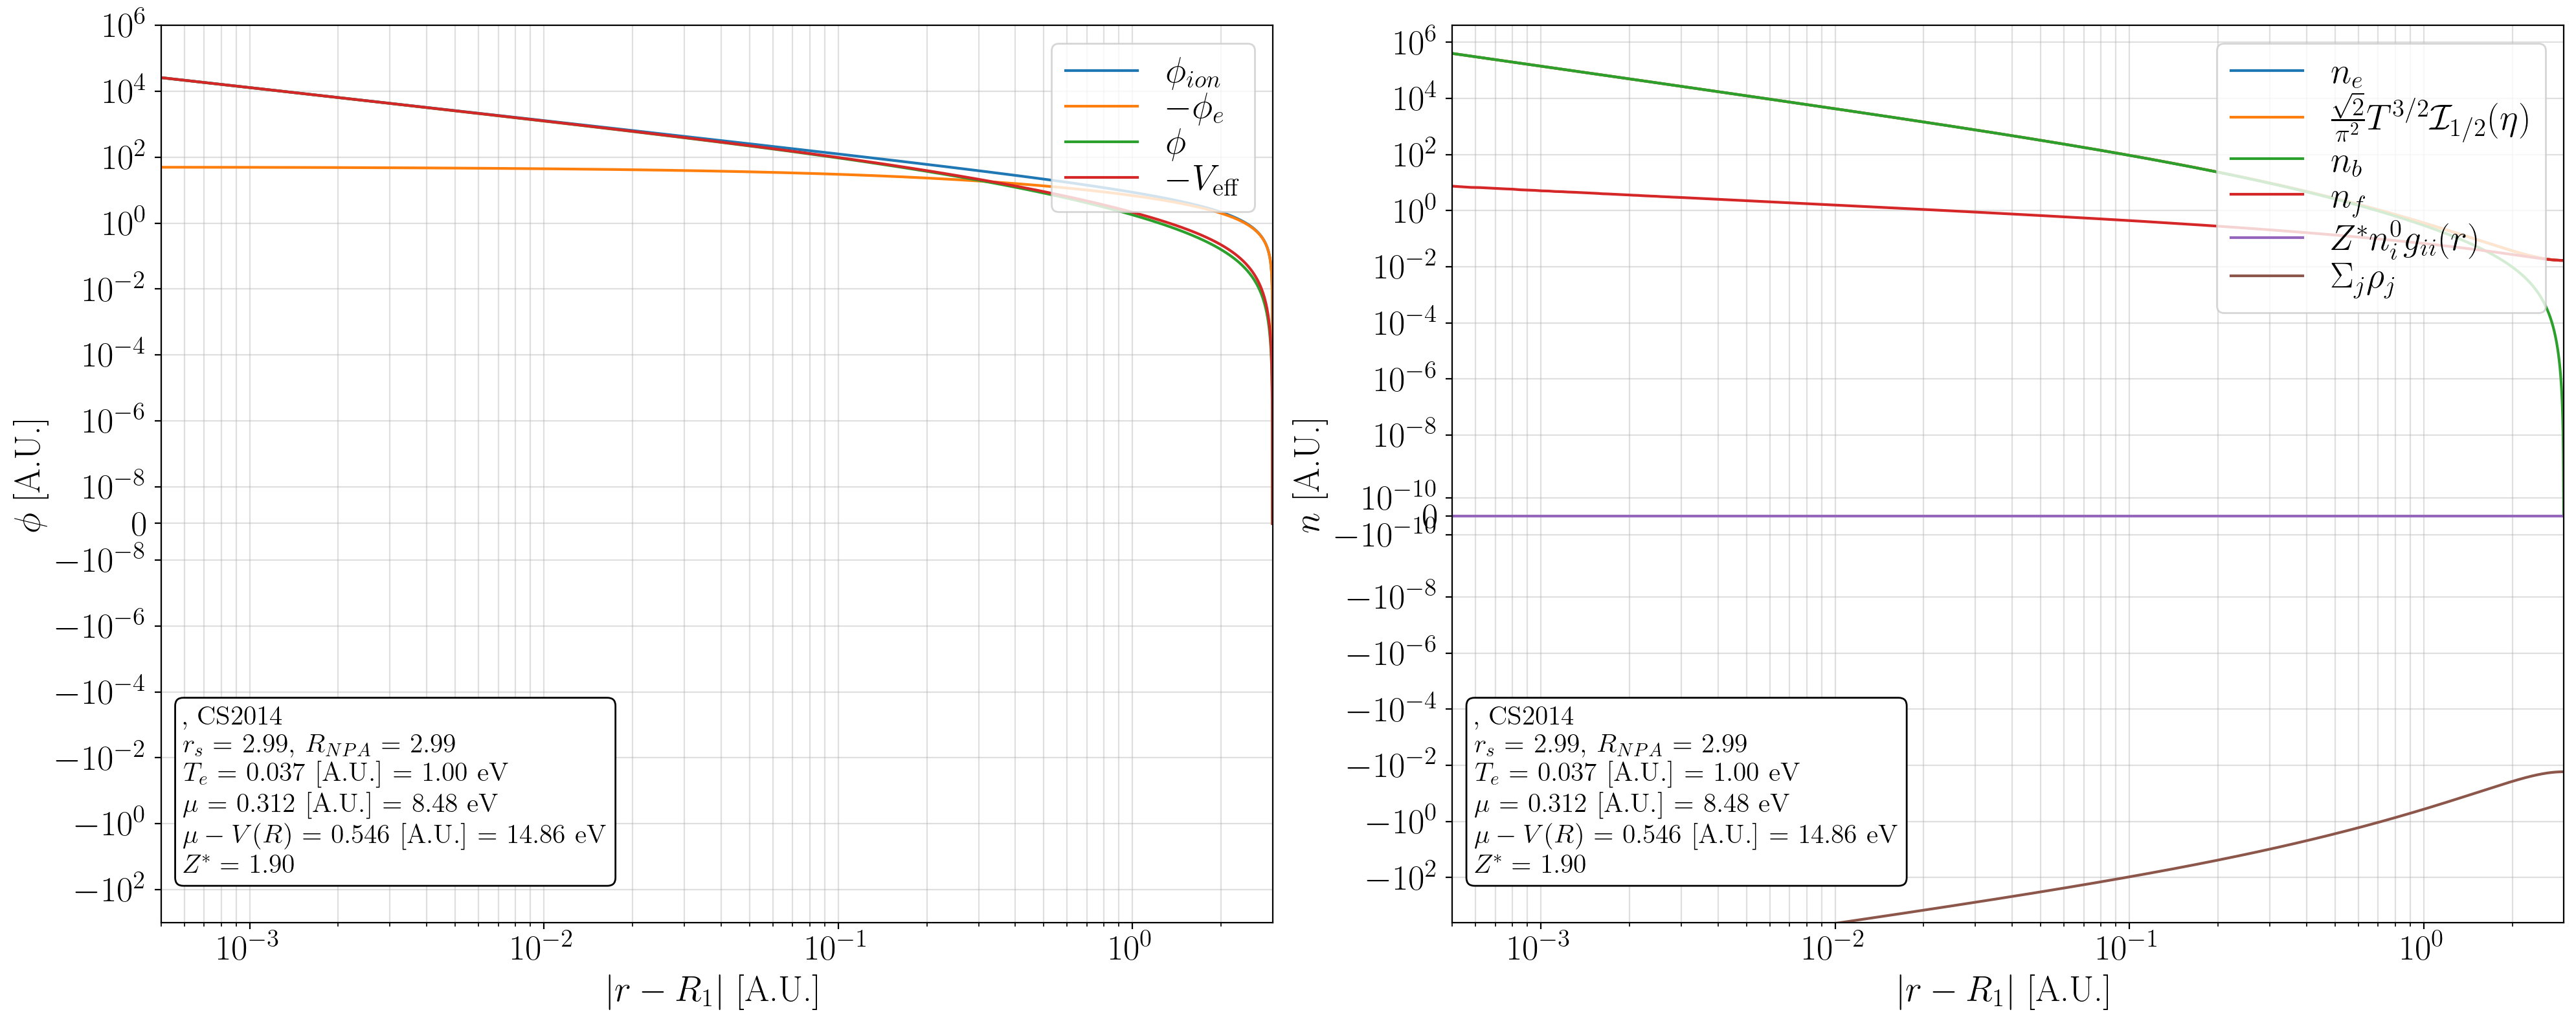

In [5]:
aa_CS.core_atom.make_plots()


Error:  name 'reload' is not defined


array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$4 \\pi r^2 n_e(r) $ [A.U.]'>,
       <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$4 \\pi r^2 n_e(r) $ [A.U.]'>],
      dtype=object)

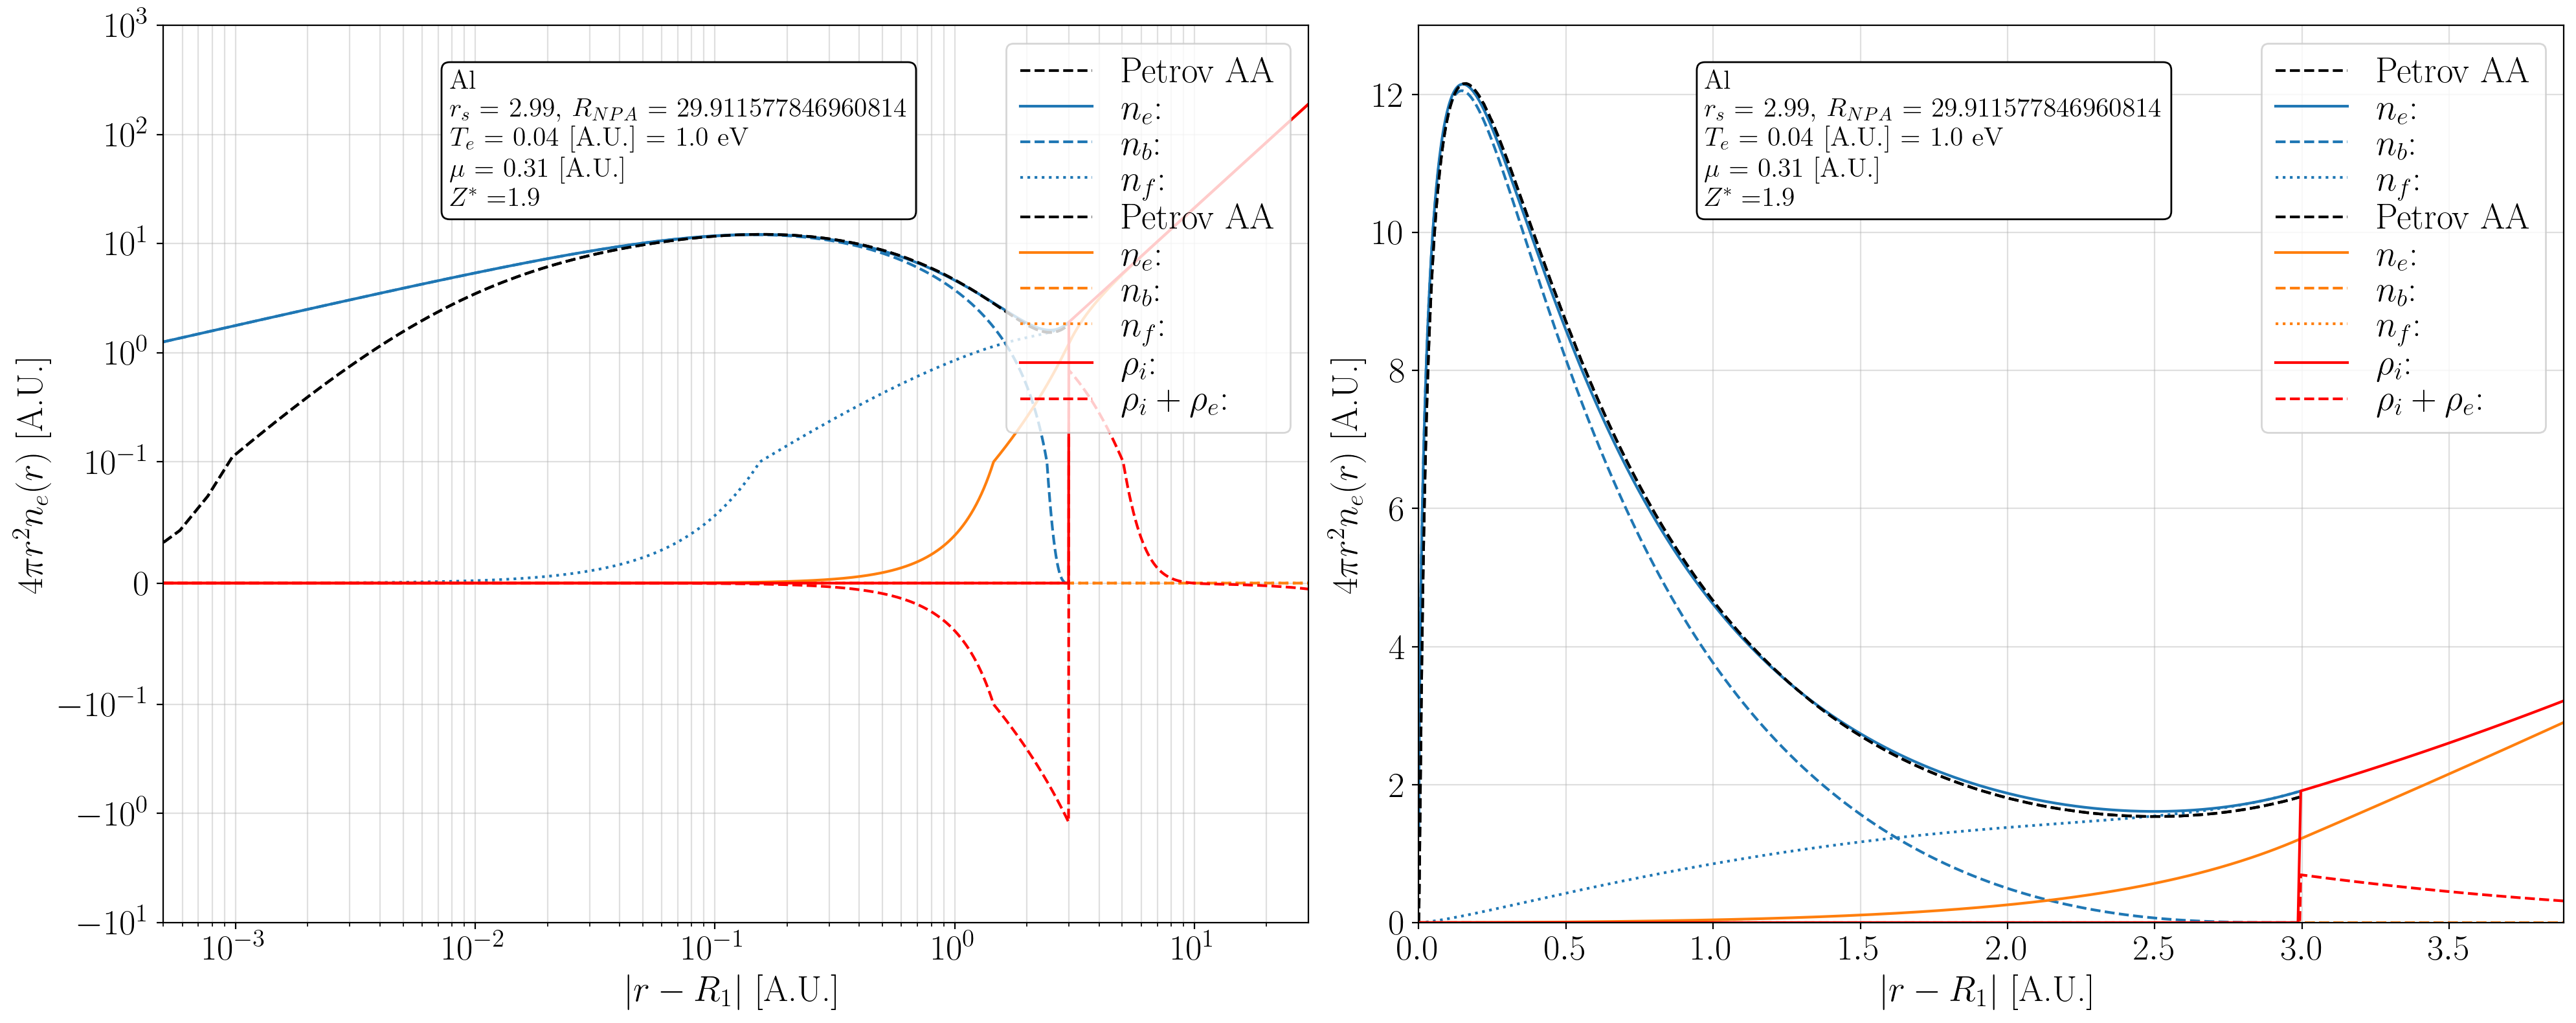

In [6]:
## from importlib import reload
try:
    reload(plotting)
except NameError as e:
    from average_atom.core import plotting as plotting
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)
    
from average_atom.core.plotting import compare_aa, plot_convergence

compare_aa([aa_CS.core_atom, aa_CS.empty_atom])

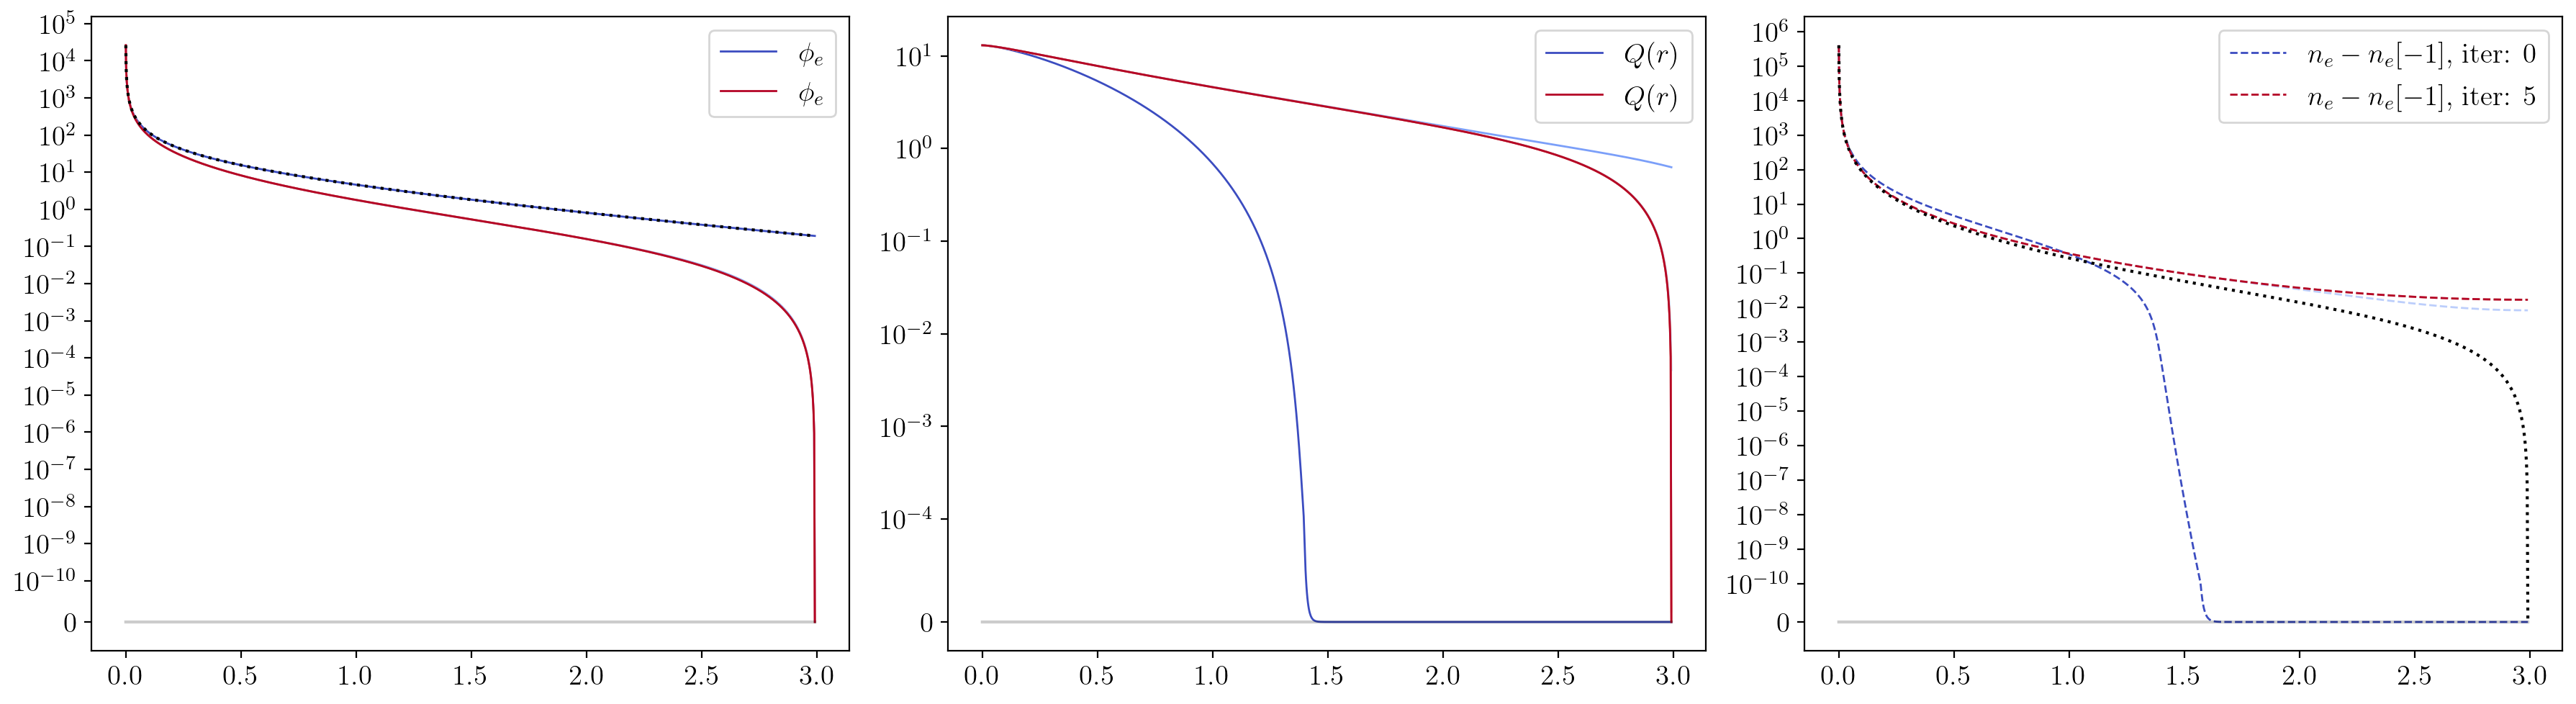

In [7]:
# plot_convergence(aa)
plot_convergence(aa_CS.core_atom)

In [8]:
def column_cleaning(frame):
    frame.columns = np.roll(frame.columns, len(frame.columns)-1)
    return frame.dropna(how='all', axis=1)

def load_NS_ne_tf_data(filename, ne_type='full'):
    NS_aa = read_csv(filename, skiprows=3, delim_whitespace=True, escapechar="#")#, names=["r", "g"])
    column_cleaning(NS_aa)
    if ne_type=='full':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['nefull'])
    elif ne_type=='bound':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['ne_ion'])
    elif ne_type=='empty':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['neext'])
    elif ne_type=='free':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['nefull'])-np.array(NS_aa['ne_ion'])
    
def load_NS_ne_ks_data(filename, ne_type='full'):
    NS_aa = read_csv(filename, skiprows=4, delim_whitespace=True, escapechar="#")#, names=["r", "g"])
    column_cleaning(NS_aa)
    if ne_type=='full':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['ne_full'])
    elif ne_type=='bound':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['ne_ion'])
    elif ne_type=='empty':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['ne_ext'])
    elif ne_type=='free':
        return np.array(NS_aa['r(a_B)']), np.array(NS_aa['ne_full'])-np.array(NS_aa['ne_ion'])


NS_folder = "/home/zach/plasma/average_atom/data/aluminum_2T/aluminum_2T_NS/"

ne_type = 'full'

# Fixed Ti cases
NS_tf_ne11 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne11 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t1ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne12 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t3ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne12 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t3ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne13 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t10ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne13 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t10ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne14 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t30ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne14 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t30ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

# Fixed Te cases
NS_tf_ne21 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t30ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne21 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti1ev_t30ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne22 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti3ev_t30ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne22 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti3ev_t30ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne23 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti10ev_t30ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne23 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti10ev_t30ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

NS_tf_ne24 = load_NS_ne_tf_data(NS_folder + "qm_ksdt_aluminum_ti30ev_t30ev_d2.7gpcc/aluminum.tfpa.dat", ne_type=ne_type)
NS_ks_ne24 = load_NS_ne_ks_data(NS_folder + "qm_ksdt_aluminum_ti30ev_t30ev_d2.7gpcc/aluminum.qmpa.dat", ne_type=ne_type)

# Mine


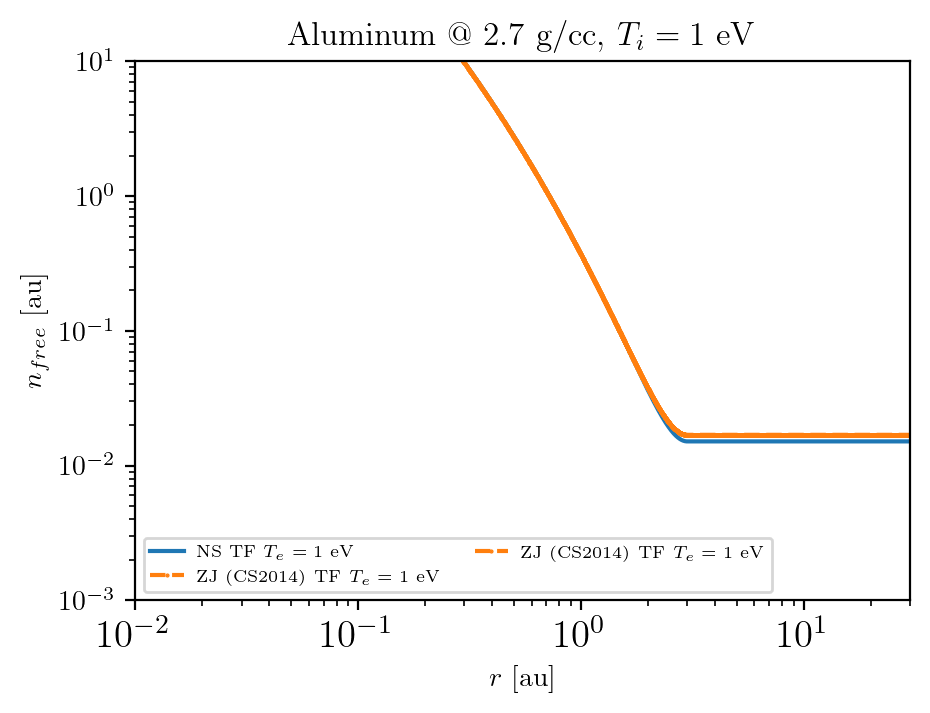

In [9]:
def plot_ne(ne_data, ks=False, figax = None, **kwargs):#line = None, color=None, label=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax  = figax
    
    fourpi = False
    if fourpi==True:
        if ks==False:
            ax.plot(ne_data[0], 4*π*ne_data[0]**2*ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        else:
            ax.plot(ne_data[0], ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        ax.set_ylabel(r"$4 \pi  r^2 n_{bound}$")        
    else:
        if ks==False:
            ax.plot(ne_data[0], ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        else:
            ax.plot(ne_data[0], (4*π*ne_data[0]**2)**-1*ne_data[1], **kwargs )#, linestyle=line, color=color, label=label)
        ax.set_ylabel(r"$n_{free} $ [au]")        

    if fourpi:
        ax.set_xlim(0,3)
        ax.set_ylim(0, 13)
    else:
        ax.set_xlim(1e-2,30)
        ax.set_yscale('log')#, linthresh=1e-3)
        ax.set_xscale('log')
        ax.set_ylim(1e-3, 1e1)

    
    ax.set_xlabel(r"$r $ [au]")
    
    ax.legend(fontsize=6, ncols=2)
    
# Fixed Ti
fig, ax = plt.subplots()
ax.set_title(r"Aluminum @ $2.7$ g/cc, $T_i = 1 $ eV")

# plot_ne(NS_ks_ne11, ks=True, figax = (fig, ax), color=color_cycle[0], linestyle='-', label=r"NS QM $T_e=1$ eV")
plot_ne(NS_tf_ne11, ks=False, figax = (fig, ax), color=color_cycle[0], linestyle='-', label=r"NS TF $T_e=1$ eV")
ZJ_csaa = np.array([aa_CS.grid.xs, aa_CS.ne_full])
plot_ne(ZJ_csaa, ks=False, figax = (fig, ax), color=color_cycle[1], linestyle='--', marker='.', markersize=1, label=r"ZJ (CS2014) TF $T_e=1$ eV")
ZJ_csaa = np.array([aa_CS.core_atom.grid.xs, aa_CS.core_atom.ne])
plot_ne(ZJ_csaa, ks=False, figax = (fig, ax), color=color_cycle[1], linestyle='--', marker='.', markersize=1, label=r"ZJ (CS2014) TF $T_e=1$ eV")

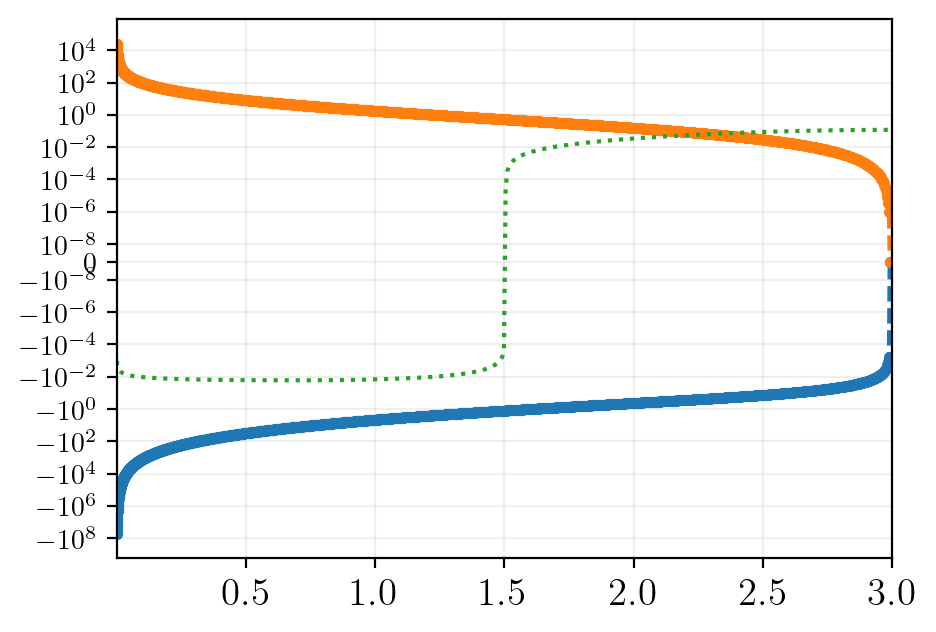

In [10]:
from scipy.interpolate import interp1d

fig, ax  = plt.subplots()

ZJ_csaa = np.array([aa_CS.grid.xs, aa_CS.ne_full])

# ax.plot(aa_CS.core_atom.grid.xs, aa_CS.grid.A_dfdx.dot(aa_CS.core_atom.φe  ), '--.')
ax.plot(aa_CS.core_atom.grid.xs, aa_CS.core_atom.grid.A_dfdx.dot(aa_CS.core_atom.φe + aa_CS.core_atom.φion ), '--.')
ax.plot(aa_CS.core_atom.grid.xs, (aa_CS.core_atom.φe + aa_CS.core_atom.φion ), '--.')
ax.plot(ZJ_csaa[0], ZJ_csaa[1]/interp1d(NS_tf_ne11[0], NS_tf_ne11[1])(ZJ_csaa[0])-1, ':')

ax.set_yscale('symlog', linthresh=1e-8)
ax.set_xlim(np.min(ZJ_csaa[0]),3)
# ax.set_xscale('log')
ax.grid(alpha=0.2)